# Gesture Recognition
In this group project, you are going to build a CNN+RNN model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize depreciated
import datetime
import os

In [2]:
from skimage.transform import resize
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('train.csv').readlines())
val_doc = np.random.permutation(open('val.csv').readlines())
batch_size = 20 #experiment with the batch size

In [5]:
resize_height=100
resize_width=100
num_image_per_video=18

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[2,4,6,8,9,10,12,14,15,16,18,20,22,23,24,25,26,28] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)#files
        num_batches = int(len(t)/batch_size)# 663/66=10
        for batch in range(num_batches): # we iterate over the number of batches#10
            x=num_image_per_video
            y=resize_height
            z=resize_width
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size#66 #t[0+(0*66)]#t[1+0]
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = plt.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image=resize(image,(y,z,3)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] =(image[:,:,0]-image[:,:,0].min())/(image[:,:,0].max()-image[:,:,0].min()) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =(image[:,:,1]-image[:,:,1].min())/(image[:,:,1].max()-image[:,:,1].min())#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =(image[:,:,2]-image[:,:,2].min())/(image[:,:,2].max()-image[:,:,2].min()) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
           
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,num_image_per_video,resize_height,resize_width,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = plt.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image=resize(image,(y,z,3)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0]-image[:,:,0].min())/(image[:,:,0].max()-image[:,:,0].min()) 
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]-image[:,:,1].min())/(image[:,:,1].max()-image[:,:,1].min()) 
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]-image[:,:,2].min())/(image[:,:,2].max()-image[:,:,2].min()) 

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = 'train'
val_path = 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,CuDNNLSTM
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers.recurrent import LSTM, GRU
from keras.applications.vgg16 import VGG16

model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=(num_image_per_video,resize_height,resize_width,3)))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(0.3))

model.add(TimeDistributed(Conv2D(64, (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(0.3))

model.add(TimeDistributed(Flatten()))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))


model.add(GRU(128, return_sequences=False))
model.add(Dense(5, activation='softmax'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
from keras.optimizers import Adam
optimiser =Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 50, 50, 8)     224       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 50, 50, 8)     32        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 48, 48, 16)    1168      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 48, 48, 16)    64        
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 24, 24, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 24, 24, 16)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 24, 24, 64)  

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.01,patience=3,min_lr=0.0001,cooldown=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
Source path =  val ; batch size = 20
Source path =  train ; batch size = 20
34/34 [==============================] - 270s 8s/step - loss: 1.8617 - categorical_accuracy: 0.2266 - val_loss: 1.5863 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2020-05-2517_09_30.172491/model-00001-1.86437-0.23228-1.58633-0.30000.h5
Epoch 2/30
34/34 [==============================] - 210s 6s/step - loss: 1.8586 - categorical_accuracy: 0.2104 - val_loss: 1.6001 - val_categorical_accuracy: 0.2400

Epoch 00002: saving model to model_init_2020-05-2517_09_30.172491/model-00002-1.85671-0.21569-1.60005-0.24000.h5
Epoch 3/30
34/34 [==============================] - 212s 6s/step - loss: 1.7363 - categorical_accuracy: 0.2693 - val_loss: 1.3791 - val_categorical_accuracy: 0.4100

Epoch 00003: saving model to model_init_2020-05-2517_09_30.172491/model-00003-1.72275-0.27602-1.37905-0.41

Epoch 29/30
34/34 [==============================] - 225s 7s/step - loss: 0.1293 - categorical_accuracy: 0.9720 - val_loss: 1.0815 - val_categorical_accuracy: 0.7100

Epoch 00029: saving model to model_init_2020-05-2517_09_30.172491/model-00029-0.13230-0.97134-1.08149-0.71000.h5
Epoch 30/30
34/34 [==============================] - 225s 7s/step - loss: 0.1325 - categorical_accuracy: 0.9720 - val_loss: 1.0877 - val_categorical_accuracy: 0.7100

Epoch 00030: saving model to model_init_2020-05-2517_09_30.172491/model-00030-0.13309-0.97134-1.08766-0.71000.h5


In [14]:
print(history.history.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


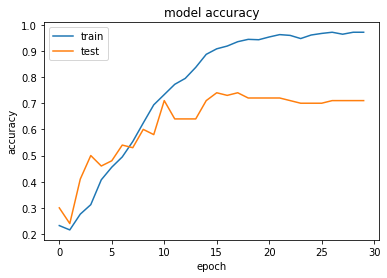

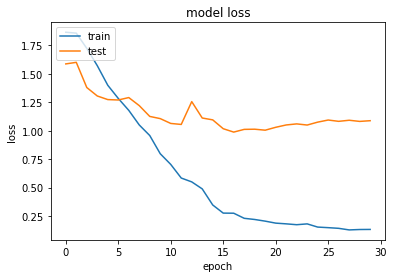

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()